In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, roc_curve, auc
import os
import pandas as pd
import random

import sys
from datetime import datetime

class Logger:
    def __init__(self, filename="log.txt"):
        self.terminal = sys.stdout
        self.log = open(filename, "a", encoding='utf-8')

    def write(self, message):
        self.terminal.write(message)   # Display in terminal
        self.log.write(message)        # Write to file

    def flush(self):
        self.terminal.flush()
        self.log.flush()

# Set up logger
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
log_filename = f"log_{timestamp}.txt"
sys.stdout = Logger(log_filename)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # You can change the seed number

In [2]:
# Define dataset paths
data_dir = r"C:\Users\dev\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray"
batch_size = 100
img_height = 256
img_width = 256

In [ ]:
from torchvision.datasets import ImageFolder

# Function to calculate mean and std
def calculate_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_images_count = 0
    for images, _ in loader:
        images = images.view(images.size(0), images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += images.size(0)
    mean /= total_images_count
    std /= total_images_count
    return mean, std

# Load datasets 
# ['train', 'val', 'test']

# Define transformations
calculate_mean_std_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
])

datasets = {x: ImageFolder(root=os.path.join(data_dir, x), transform=calculate_mean_std_transform) for x in ['train']}
loaders = {x: DataLoader(datasets[x], batch_size=batch_size, shuffle=False) for x in ['train']}

# Calculate mean and std for each dataset
mean_std = {x: calculate_mean_std(loaders[x]) for x in ['train']}
target_mean = mean_std['train'][0].numpy()[0]
target_std = mean_std['train'][1].numpy()[0]
print(target_mean,target_std)

0.47574726 0.22447172


In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[target_mean], std=[target_std])
])

In [6]:
import pickle
def load_train_test_loader(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(f)
    
train_test_loader = load_train_test_loader("train_test_loader_scale.pkl")
train_loader = train_test_loader['train_loader']
train_classes = train_test_loader['train_classes']
test_loader = train_test_loader['test_loader']
test_classes = train_test_loader['test_classes']

In [8]:
# Class names
print("Class Names:", train_classes)

Class Names: ['NORMAL', 'PNEUMONIA']


In [9]:
# Define CNN model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * (img_height // 8) * (img_width // 8), 128)
        # self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

In [11]:
# Initialize model
model = CNN(num_classes=len(train_classes))
# model = torchvision.models.mobilenet_v3_large(pretrained=False)
# model.features[0][0] = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False)
# model.classifier[3] = nn.Linear(model.classifier[3].in_features, len(class_names))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [12]:
# Train the model
epochs = 20
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    ## update step
    # for images, labels in train_loader:
    #     images, labels = images.to(device), labels.to(device)
    #     optimizer.zero_grad()
    #     outputs = model(images)
    #     loss = criterion(outputs, labels)
    #     loss.backward()
    #     optimizer.step()
    #     running_loss += loss.item()
    #     _, predicted = torch.max(outputs, 1)
    #     total += labels.size(0)
    #     correct += (predicted == labels).sum().item()

    ## update epoch

    optimizer.zero_grad()
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
    
    optimizer.step()



    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    scheduler.step()
    
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()[:, 1])
    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/20 - Train Loss: 0.6920, Train Acc: 0.5010, Val Loss: 0.6822, Val Acc: 0.5000
Epoch 2/20 - Train Loss: 0.6704, Train Acc: 0.5000, Val Loss: 0.6588, Val Acc: 0.5425
Epoch 3/20 - Train Loss: 0.6378, Train Acc: 0.7100, Val Loss: 0.6247, Val Acc: 0.8025
Epoch 4/20 - Train Loss: 0.5961, Train Acc: 0.8350, Val Loss: 0.6027, Val Acc: 0.7625
Epoch 5/20 - Train Loss: 0.5714, Train Acc: 0.7800, Val Loss: 0.5817, Val Acc: 0.8150
Epoch 6/20 - Train Loss: 0.5374, Train Acc: 0.8590, Val Loss: 0.5766, Val Acc: 0.7875
Epoch 7/20 - Train Loss: 0.5165, Train Acc: 0.8810, Val Loss: 0.5535, Val Acc: 0.8175
Epoch 8/20 - Train Loss: 0.4913, Train Acc: 0.8890, Val Loss: 0.5309, Val Acc: 0.8225
Epoch 9/20 - Train Loss: 0.4739, Train Acc: 0.8820, Val Loss: 0.5199, Val Acc: 0.8250
Epoch 10/20 - Train Loss: 0.4579, Train Acc: 0.8915, Val Loss: 0.5235, Val Acc: 0.7975
Epoch 11/20 - Train Loss: 0.4428, Train Acc: 0.9085, Val Loss: 0.5237, Val Acc: 0.7975
Epoch 12/20 - Train Loss: 0.4416, Train Acc: 0.9080,

In [13]:
# Classification report
report = classification_report(y_true, y_pred, target_names=train_classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)

              precision  recall  f1-score   support
NORMAL         0.865497  0.7400  0.797844  200.0000
PNEUMONIA      0.772926  0.8850  0.825175  200.0000
accuracy       0.812500  0.8125  0.812500    0.8125
macro avg      0.819211  0.8125  0.811509  400.0000
weighted avg   0.819211  0.8125  0.811509  400.0000


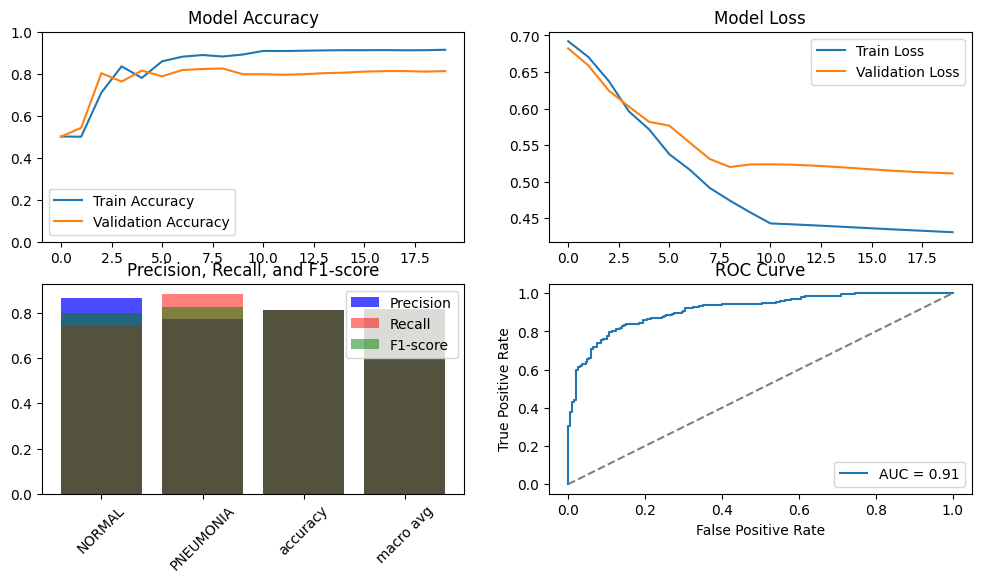

In [ ]:

# Plot metrics
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.title("Model Accuracy")

plt.subplot(2, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title("Model Loss")

plt.subplot(2, 2, 3)
plt.bar(df_report.index[:-1], df_report['precision'][:-1], color='blue', alpha=0.7, label='Precision')
plt.bar(df_report.index[:-1], df_report['recall'][:-1], color='red', alpha=0.5, label='Recall')
plt.bar(df_report.index[:-1], df_report['f1-score'][:-1], color='green', alpha=0.5, label='F1-score')
plt.xticks(rotation=45)
plt.legend()
plt.title("Precision, Recall, and F1-score")

plt.subplot(2, 2, 4)
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve")

# Save the figure before showing it
plt.tight_layout()
plt.savefig("model_metrics_plot.png", dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# Save the model
torch.save(model.state_dict(), "xray_classifier.pth")
print("Model saved as xray_classifier.pth")

Model saved as xray_classifier.pth
